# Simulated Annealing - TSP Example Case
- Nathan Rooy | June. 2020
- https://github.com/nathanrooy/simulated-annealing

### Import dependencies

In [1]:
from simulated_annealing import sa
from landscapes.single_objective import tsp

import pandas as pd
import osmnx as ox
import networkx as nx

### TSP - Breweries (network distance)

In [2]:
# load distance matrix as dict
dist_dict = {}
with open('dist_table.csv','r') as csv_file:
    for i, row in enumerate(csv_file.readlines()):
        if i == 0: pass
        else:
            n1, n2, dist = row.split(',')
            dist_dict[n1, n2] = float(dist.replace('\n',''))

In [3]:
# new distance function based on network lookup table
def calc_dict(p1, p2, dist_dict=dist_dict):   
    return dist_dict[p1,p2]

In [4]:
# create initial tsp path
x0 = []
for item in dist_dict.keys():
    x0.append(item[0])
    x0.append(item[1])
x0 = list(set(x0))

In [5]:
tsp_bike = tsp(dist_func=calc_dict, close_loop=True).dist

In [6]:
# initial energy
tsp_bike(x0)

86614.416

In [7]:
# initial distance (miles)
tsp_bike(x0) * 0.000621371

53.819686284336

In [8]:
# minimize
opt = sa.minimize(tsp_bike, x0, opt_mode='combinatorial', step_max=1000, t_max=1000, t_min=0) 

In [9]:
opt.results()

+------------------------ RESULTS -------------------------+

      opt.mode: combinatorial
cooling sched.: linear additive cooling


  initial temp: 1000
    final temp: 1.000000
     max steps: 1000
    final step: 1000

  final energy: 51104.006000

+-------------------------- END ---------------------------+


In [10]:
# shortest distance (miles)
tsp_bike(opt.best_state) * 0.000621371

31.754547312226002

In [11]:
opt.best_state

['MadTree Brewing',
 'Listermann Brewing Company',
 'Urban Artifact',
 'Rhinegeist Brewery',
 'Christian Moerlein Brewing Co.',
 "Taft's Ale House",
 'Braxton Brewing Company',
 '3 Points Urban Brewery',
 'The Woodburn Brewery',
 'Fifty West Brewing Company']

In [16]:
# sanity check
G =  ox.io.load_graphml('cincy.graphml')

In [17]:
# load brewery locations
locs_df = pd.read_csv('brewery_locations.csv')

In [18]:
# calculate bounding box
lats = locs_df['lat'].values
lngs = locs_df['lng'].values
bbox = [max(lats), min(lats), max(lngs), min(lngs)]

In [19]:
def calc_route(n0, n1):
    p0 = locs_df[locs_df['name']==n0][['lat','lng']].values[0]
    p1 = locs_df[locs_df['name']==n1][['lat','lng']].values[0]
    p0_node = ox.get_nearest_node(G, p0)
    p1_node = ox.get_nearest_node(G, p1)
    return nx.shortest_path(G, p0_node, p1_node, weight="length")

In [20]:
# generate initial route
route_initial = []
for i in range(len(x0)-1):
    n0 = x0[i]
    n1 = x0[i+1]
    route_initial.append(calc_route(n0, n1))
    
# close the loop
route_initial.append(calc_route(x0[0], x0[-1]))

In [21]:
# generate optimal route
route_final = []
for i in range(len(opt.best_state)-1):
    n0 = opt.best_state[i]
    n1 = opt.best_state[i+1]
    route_final.append(calc_route(n0, n1))
    
# close the loop
route_final.append(calc_route(opt.best_state[0], opt.best_state[-1]))

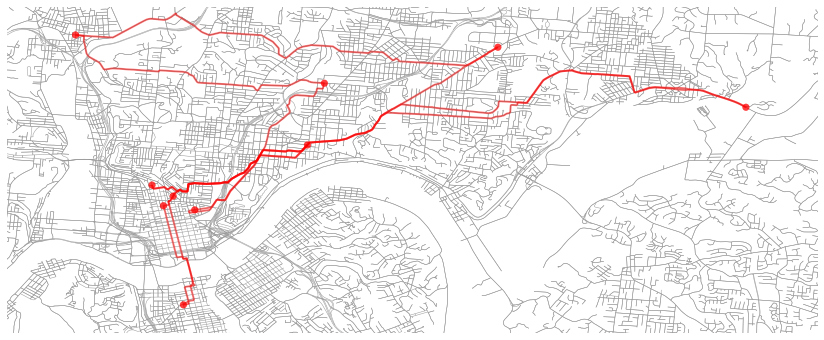

In [22]:
# initial
fig, ax = ox.plot_graph_routes(
    G, 
    route_initial,
    bbox=bbox,
    margin=0.1,
    edge_linewidth=0.5,
    route_linewidth=2,
    orig_dest_node_size=50,
    node_size=0,
    save=True,
    filename='cincy_initial',
    dpi=100)

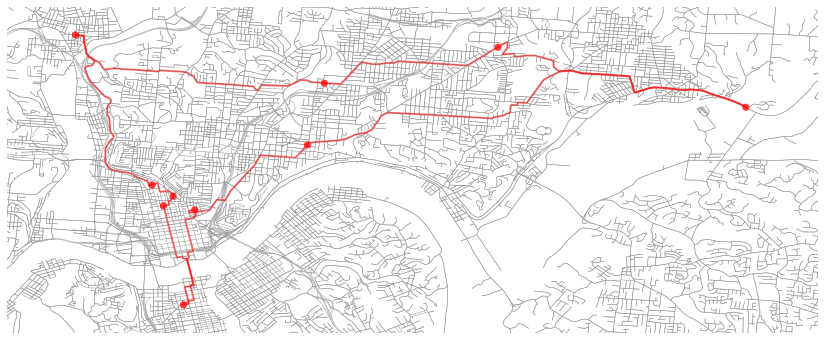

In [23]:
# final
lats = locs_df['lat'].values
lngs = locs_df['lng'].values

bbox = [max(lats), min(lats), max(lngs), min(lngs)]

fig, ax = ox.plot_graph_routes(
    G, 
    route_final,
    bbox=bbox,
    margin=0.1,
    edge_linewidth=0.5,
    route_linewidth=2,
    orig_dest_node_size=50,
    node_size=0,
    save=True,
    filename='cincy_final',
    dpi=100)